# Denoising MIAS Dataset using AutoEncoders

In [33]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [104]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)


1.9.0+cu111
cuda:0


### Download & extract the MIAS dataset


In [115]:
MIAS_URL = "http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz"
MIAS_DATASET_DIR = Path("./datasets/mias")
MIAS_MODEL_DIR = Path("./models/mias")

if not MIAS_DATASET_DIR.exists():
    !mkdir {MIAS_DATASET_DIR / 'all-mias'}
    !wget -P {MIAS_DATASET_DIR} {MIAS_URL}
    !tar -xf {MIAS_DATASET_DIR / "all-mias.tar.gz"} --directory {MIAS_DATASET_DIR / 'all-mias'}

if not MIAS_MODEL_DIR.exists():
    !mkdir {MIAS_MODEL_DIR}


In [71]:
FEATURE_SHAPE = 64
BATCH_SIZE = 10
TRAIN_TEST_SPLIT = 0.9

# ? Resize the images and convert to grayscale tensors
transform = transforms.Compose(
    [
        transforms.Resize(FEATURE_SHAPE),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder(MIAS_DATASET_DIR, transform)

# ? Split dataset into train and test sets
train_size = int(TRAIN_TEST_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ? Create dataset loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Visualize MIAS dataset

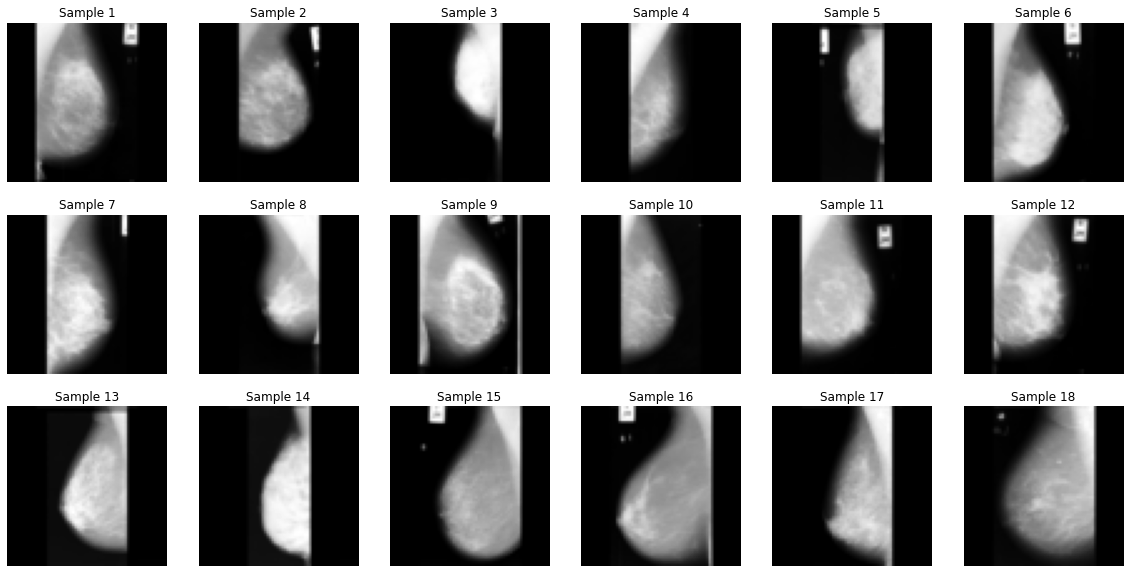

In [67]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    fig_img, fig_label = train_dataset[i]
    fig_img = fig_img.permute(1, 2, 0)

    ax.imshow(fig_img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Sample {i+1}")


### Generate noisy data


In [85]:
def add_noise(input, mean=0, std=1, propogation=0.1):
    noise = torch.normal(mean=mean, std=std, size=input.shape, device=device)
    output = input + propogation * noise

    return output


### Visualize noisy data


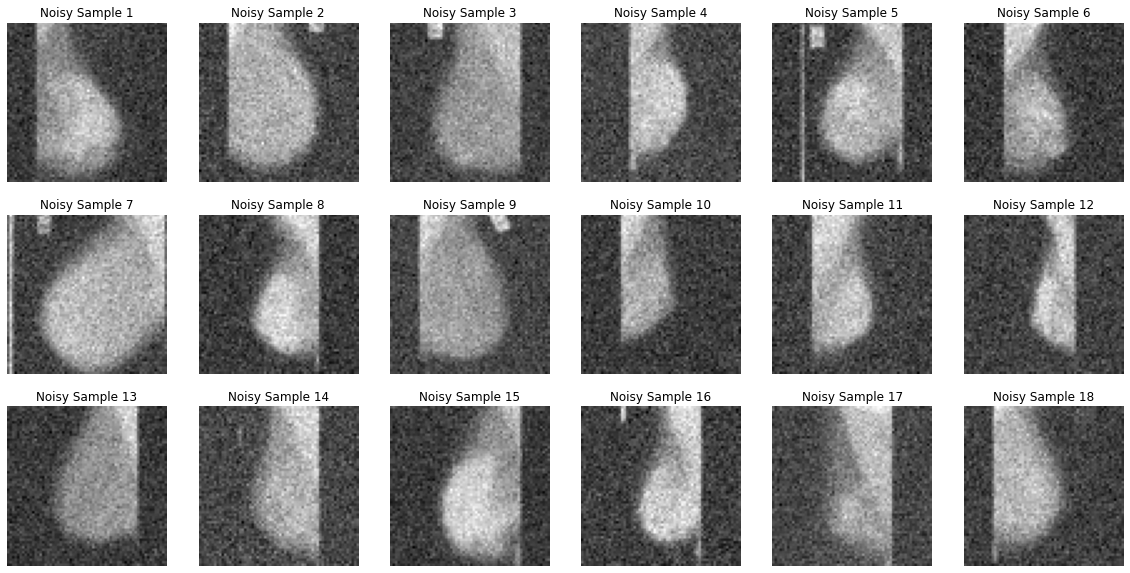

In [83]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    fig_img, fig_label = train_dataset[i]
    fig_img = add_noise(fig_img)
    fig_img = fig_img.permute(1, 2, 0)

    ax.imshow(fig_img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Noisy Sample {i+1}")


### Build CNN based AutoEncoder Model

In [110]:
class PrintShape(nn.Module):
    def __init__(self, key=None):
        super().__init__()

        self.key = key

    def forward(self, x):
        print(self.key, x.shape)

        return x


class AutoEncoderCNN(nn.Module):
    def __init__(self, channels=1):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # ? shape of x: (BATCH_SIZE, channels, FEATURE_SHAPE, FEATURE_SHAPE)
        x = self.encoder(x)
        x = self.decoder(x)

        return x


AutoEncoderCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [182]:
def train(model, train_loader, optimizer, criterion, epochs, device, save_interval=20, log_interval=10):
    print("Training started...")
    losses = []

    for epoch in range(1, epochs + 1):
        epoch_loss = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()

            pure = data.to(device)
            noisy = add_noise(pure)
            denoised = model(noisy)

            loss = criterion(denoised, pure)
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print(
                    f'Epoch: {epoch}\t'
                    f'[{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\t'
                    f'Loss: {loss.item() / BATCH_SIZE:.6f}'
                )
            epoch_loss += loss.item()

        losses.append(epoch_loss / len(train_loader.dataset))
        if epoch % save_interval == 0:
            torch.save(model.state_dict(), MIAS_MODEL_DIR / f"autoencodercnn_mias_epoch_{epoch}.pth")

    return losses


In [117]:
model = AutoEncoderCNN()
model.to(device)
print(model.parameters())

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = train(model, train_loader, optimizer=optimizer, criterion=criterion, epochs=100, device=device)
plt.plot(train_losses)


Training started...
Epoch: 1	[0/289 (0%)]	Loss: 0.704611
Epoch: 1	[100/289 (34%)]	Loss: 0.344522
Epoch: 1	[200/289 (69%)]	Loss: 0.282831
Epoch: 2	[0/289 (0%)]	Loss: 0.322209
Epoch: 2	[100/289 (34%)]	Loss: 0.256273
Epoch: 2	[200/289 (69%)]	Loss: 0.265733
Epoch: 3	[0/289 (0%)]	Loss: 0.255340
Epoch: 3	[100/289 (34%)]	Loss: 0.262918
Epoch: 3	[200/289 (69%)]	Loss: 0.289028
Epoch: 4	[0/289 (0%)]	Loss: 0.276869
Epoch: 4	[100/289 (34%)]	Loss: 0.346080
Epoch: 4	[200/289 (69%)]	Loss: 0.235650
Epoch: 5	[0/289 (0%)]	Loss: 0.266569
Epoch: 5	[100/289 (34%)]	Loss: 0.295604
Epoch: 5	[200/289 (69%)]	Loss: 0.273900
Epoch: 6	[0/289 (0%)]	Loss: 0.262127
Epoch: 6	[100/289 (34%)]	Loss: 0.244107
Epoch: 6	[200/289 (69%)]	Loss: 0.302929
Epoch: 7	[0/289 (0%)]	Loss: 0.245000
Epoch: 7	[100/289 (34%)]	Loss: 0.251016
Epoch: 7	[200/289 (69%)]	Loss: 0.239555
Epoch: 8	[0/289 (0%)]	Loss: 0.282680
Epoch: 8	[100/289 (34%)]	Loss: 0.215189
Epoch: 8	[200/289 (69%)]	Loss: 0.264929
Epoch: 9	[0/289 (0%)]	Loss: 0.279144
Epoch: 

### Test the model


In [145]:
def test(model, test_loader, device):
    model.eval()

    test_loss = 0
    noisy_imgs = []
    denoised_imgs = []

    with torch.no_grad():
        for data, _ in test_loader:
            pure = data.to(device)
            noisy = add_noise(pure)
            denoised = model(noisy)

            loss = criterion(denoised, pure)
            test_loss += loss.item()

            for i, (n, d) in enumerate(zip(noisy, denoised)):
                noisy_imgs.append(n.cpu())
                denoised_imgs.append(d.cpu())

    test_loss /= len(test_loader.dataset)
    print(f"Average test loss: {test_loss:.6f}")

    return noisy_imgs, denoised_imgs


In [146]:
model = AutoEncoderCNN()
model.load_state_dict(torch.load(MIAS_MODEL_DIR / "autoencodercnn_mias_epoch_100.pth"))
model.to(device)

noisy_imgs, denoised_imgs = test(model, test_loader, device=device)


Average test loss: 0.029057


### Visualize results

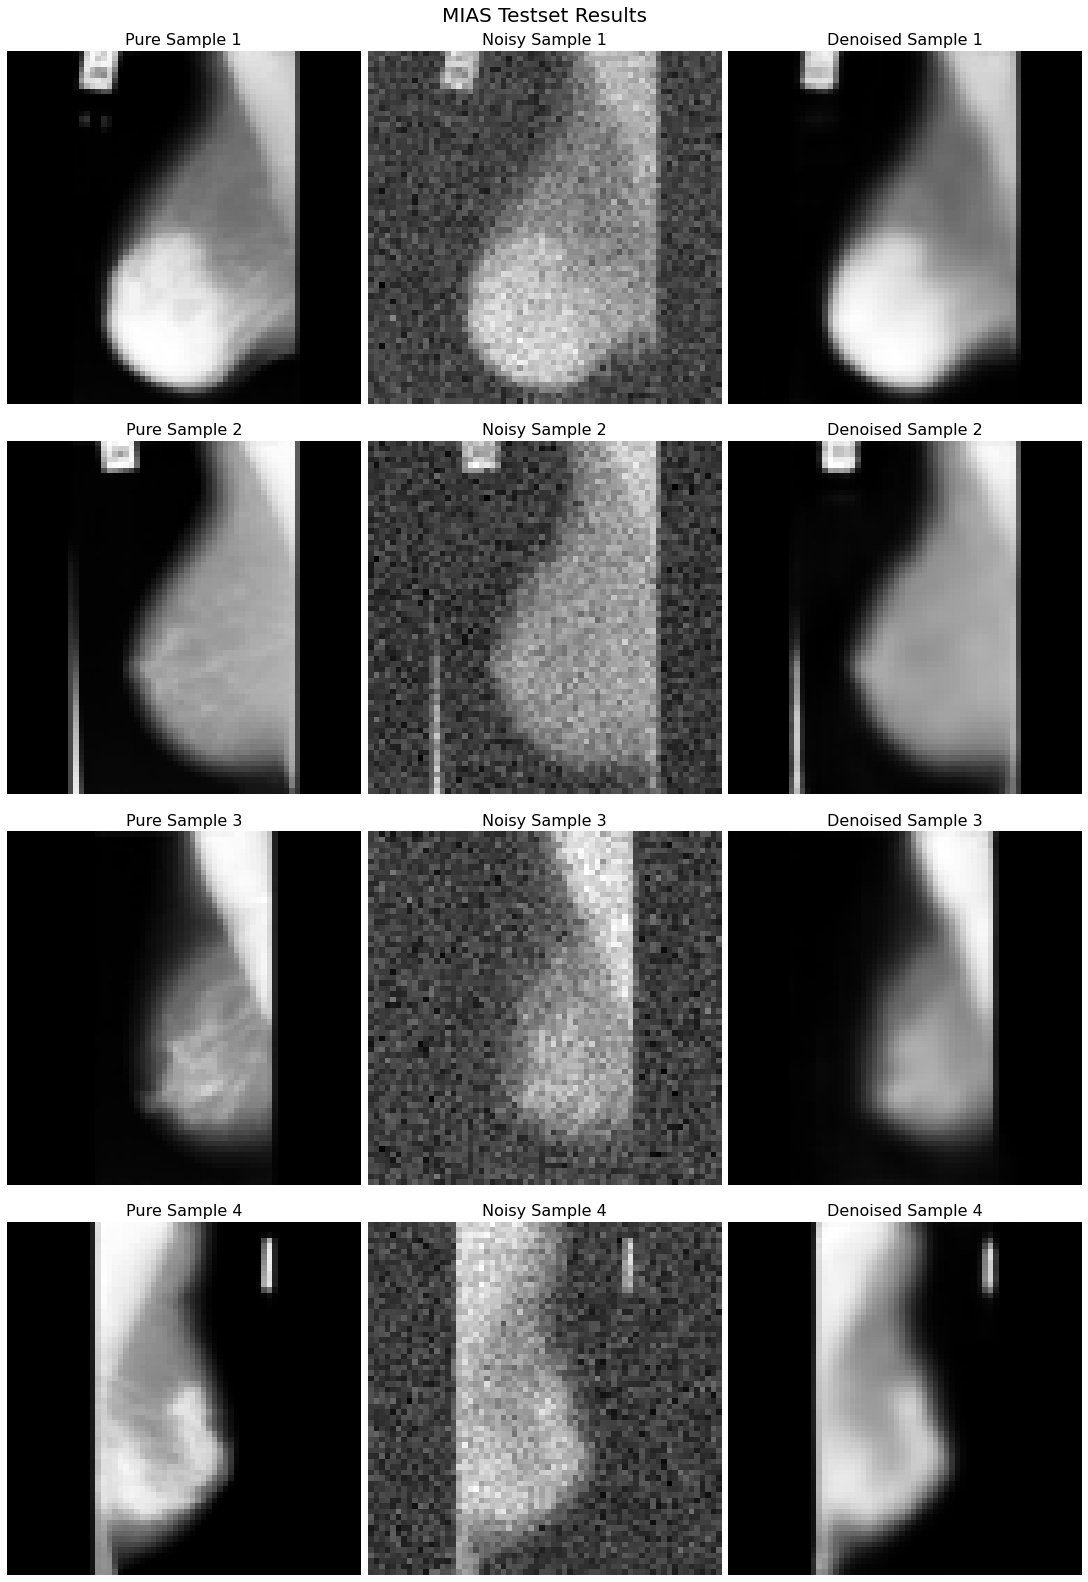

In [181]:
fig, axes = plt.subplots(4, 3, figsize=(15, 22), constrained_layout=True)
fig.suptitle("MIAS Testset Results", fontsize=20)

for i, ax in enumerate(axes):
    ax[0].imshow(test_dataset[i][0].permute(1, 2, 0), cmap="gray")
    ax[0].axis("off")
    ax[0].set_title(f"Pure Sample {i+1}", fontsize=16)

    ax[1].imshow(noisy_imgs[i].permute(1, 2, 0), cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Noisy Sample {i+1}", fontsize=16)

    ax[2].imshow(denoised_imgs[i].permute(1, 2, 0), cmap="gray")
    ax[2].axis("off")
    ax[2].set_title(f"Denoised Sample {i+1}", fontsize=16)
